In [1]:
import pandas as pd
from astropy.table import Table, QTable
import numpy as np
import matplotlib.pyplot as plt
import ellipsoid

from astropy.time import Time
from astropy.coordinates import SkyCoord
from astropy import units as u

from astroquery.gaia import Gaia
import random

### Read in photometry data from Open Astronomy Catalog
#### API description at https://github.com/astrocatalogs/OACAPI

In [2]:
data = pd.read_csv('https://api.astrocats.space/SN1987A/photometry/time+band+magnitude?format=csv')
data = data.dropna()

In [3]:
photometry = Table.from_pandas(data)

In [4]:
vmask = photometry['band']=='V'

In [5]:
# Subtract MJD of February 23, 1987 (date of observation)
photometry['time'] = photometry['time']-46849

In [6]:
lc = photometry[vmask]

(18.0, 2.0)

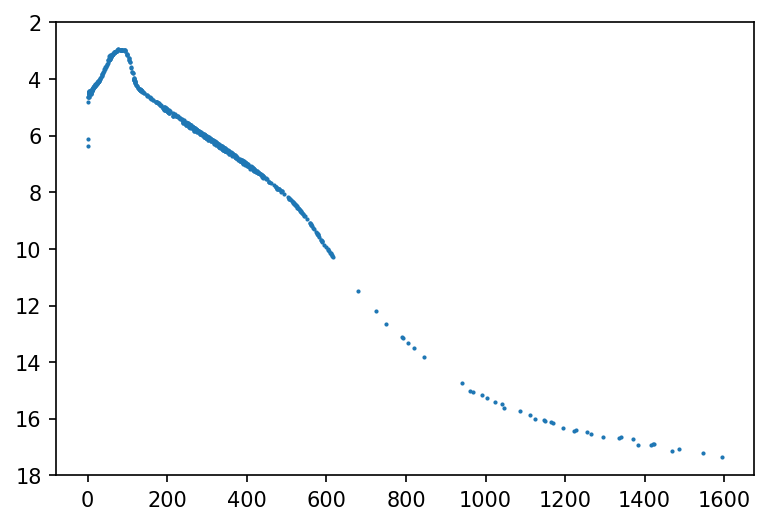

In [7]:
fig = plt.figure(figsize=[6,4], dpi=150)
plt.scatter(lc['time'], lc['magnitude'], s=1)
plt.ylim(18,2)

#### Get a random light curve from the crossing list

In [23]:
file_name = 'Gaia_var_class'
c1, stars = ellipsoid.readFile(file_name)
tol = 0.1
start = 2014.569312182902

In [24]:
#Properties of SN1987A
t0 = Time({'year': 1987, 'month': 2, 'day': 23}, format='ymdhms')

c0_radec = SkyCoord.from_name('SN 1987A')

# Panagia (1999) https://ui.adsabs.harvard.edu/abs/1999IAUS..190..549P/abstract
d0 = 51.4 * u.kpc
d0_err = 1.2 * u.kpc

c0 = SkyCoord(ra=c0_radec.ra, dec=c0_radec.dec, distance=d0)

In [25]:
c1_x, stars_x = ellipsoid.crossErrorEllipsoid(c0, t0, c1, stars, tol)
print(f'{len(stars_x)} stars have crossed the ellipsoid during Gaia DR3 data collection time')

217 stars have crossed the ellipsoid during Gaia DR3 data collection time


In [26]:
ids = stars_x['id']

In [27]:
merged_sf = '../GCNS_var_lc.xml'
lc_merged = QTable.read(merged_sf, format='votable')

In [28]:
glcDict = {}
bplcDict = {}
rplcDict = {}

In [29]:
for sid in ids:
    glc, bplc, rplc = ellipsoid.getLC(lc_merged, sid, 'G'), ellipsoid.getLC(lc_merged, sid, 'BP'), ellipsoid.getLC(lc_merged, sid, 'RP')
    glcDict[str(sid)], bplcDict[str(sid)], rplcDict[str(sid)] = glc, bplc, rplc

In [30]:
lcChoice = random.choice(list(glcDict.keys()))

In [31]:
id_mask = stars_x['id'] == int(lcChoice)

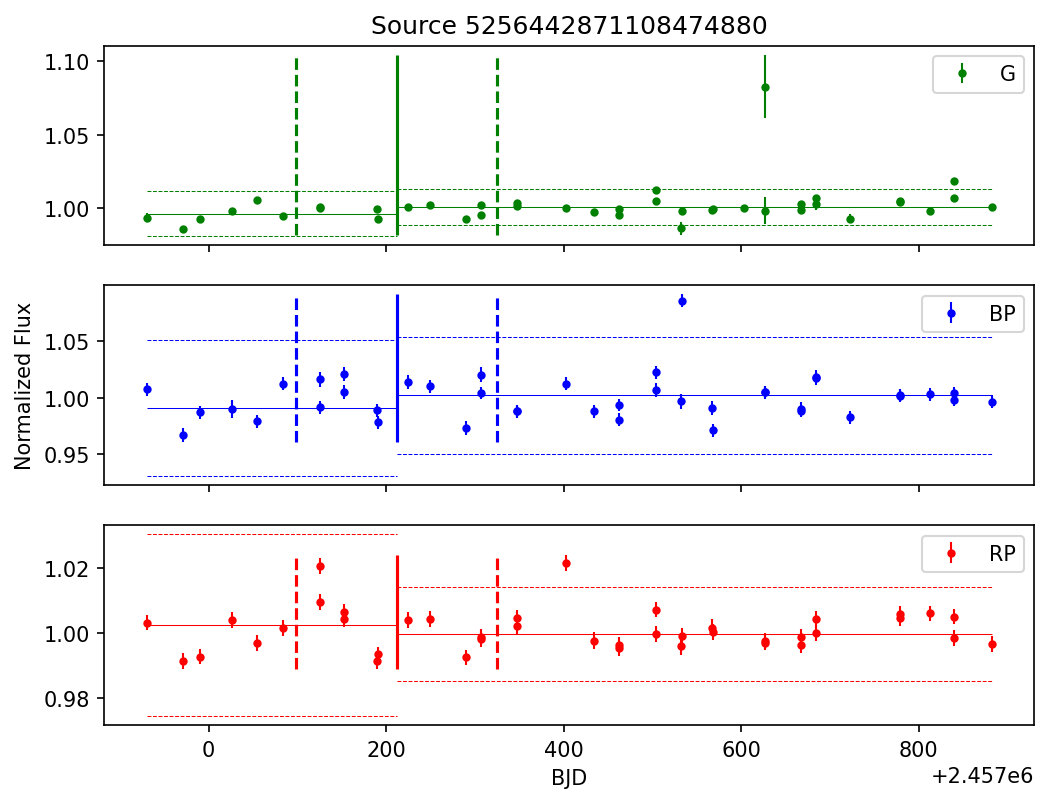

In [32]:
ellipsoid.plotLC(str(lcChoice), c1_x[id_mask], stars_x[id_mask], glcDict, bplcDict, rplcDict, y='flux')

In [33]:
xtime = ellipsoid.xTime(c1_x[id_mask])[0]

In [34]:
lcDict = glcDict # choose g, bp, or rp light curve

lcTimes = Time(lcDict[lcChoice]['time'].value + 2455197.5, format='jd')
lcFlux = lcDict[lcChoice]['flux']
lcFerr = lcDict[lcChoice]['flux_error']
lcMag = lcDict[lcChoice]['mag']
# time offset described at https://gea.esac.esa.int/archive/documentation/GDR3/Gaia_archive/chap_datamodel/sec_dm_photometry/ssec_dm_epoch_photometry.html

#### Cross-correlation

In [35]:
# Add crossing time to supernova light curve times
lc['time'] = lc['time'] + xtime

In [38]:
# Add "normalized flux" column
lc['flux'] = (10**(-0.4*lc['magnitude']))/np.max(10**(-0.4*lc['magnitude']))/100 + 1

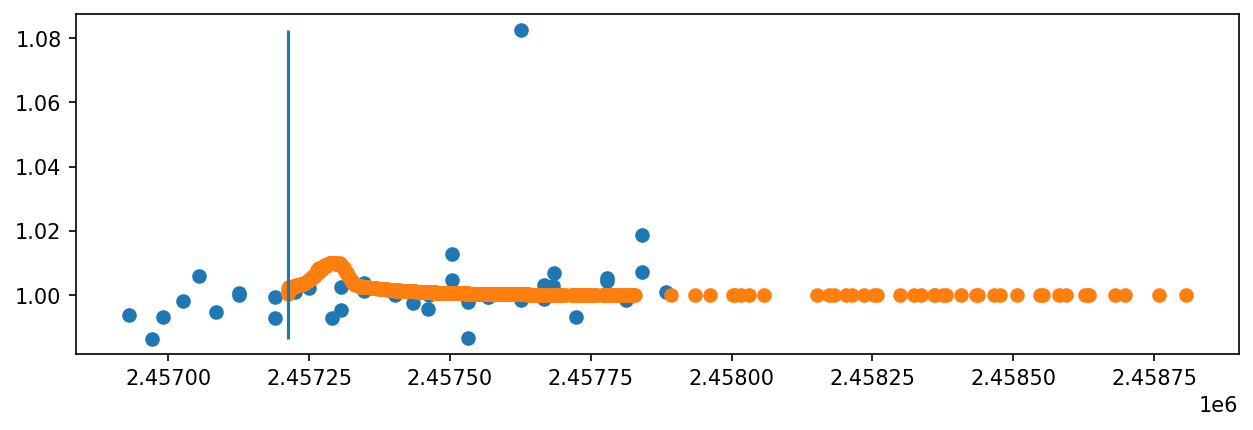

In [39]:
plt.figure(figsize=[10,3], dpi=150)

plt.vlines(xtime, ymin=min(lcFlux.value), ymax=max(lcFlux.value))
plt.scatter(lcTimes.value, lcFlux)
plt.scatter(lc['time'], lc['flux'])

In [40]:
from scipy.interpolate import interp1d

In [41]:
f = interp1d(lc['time'], lc['flux'])

In [42]:
rtimes = lcTimes.value >= xtime

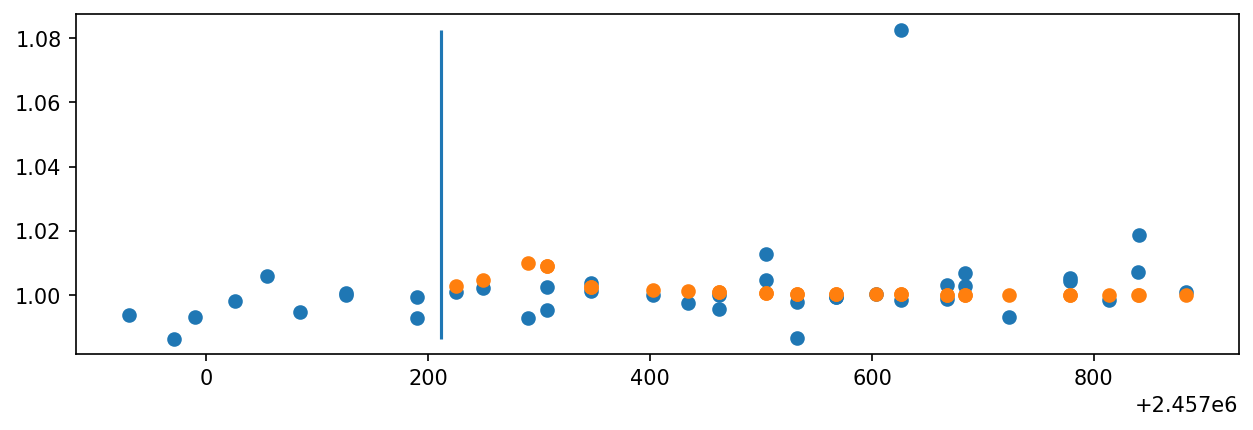

In [43]:
plt.figure(figsize=[10,3], dpi=150)

plt.vlines(xtime, ymin=min(lcFlux.value), ymax=max(lcFlux.value))
plt.scatter(lcTimes.value, lcFlux)
plt.scatter(lcTimes.value[rtimes], f(lcTimes.value[rtimes]))

In [44]:
from scipy.signal import correlate

In [46]:
corrLC = correlate(lcFlux[rtimes], f(lcTimes.value[rtimes]), mode='same') / (len(lcFlux[rtimes])/2)

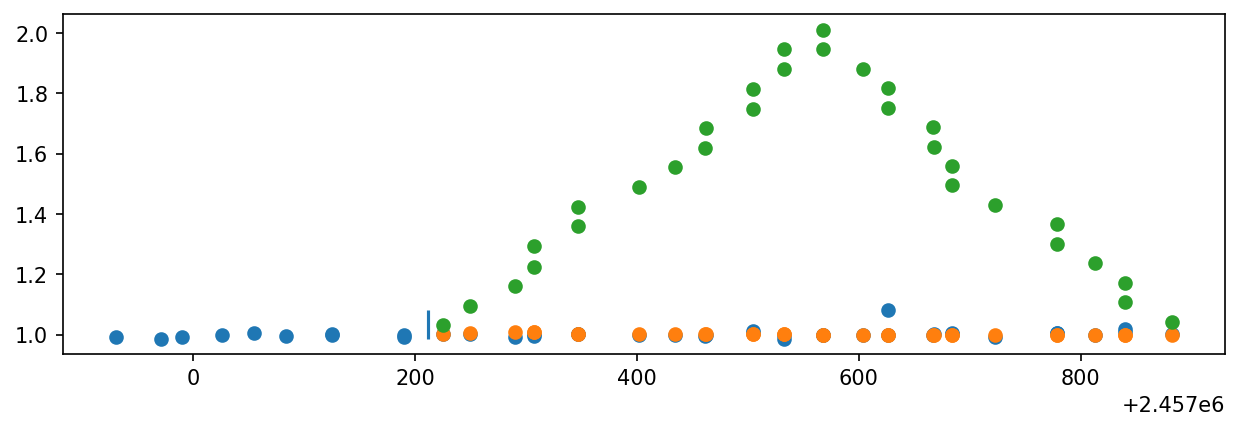

In [47]:
plt.figure(figsize=[10,3], dpi=150)

plt.vlines(xtime, ymin=min(lcFlux.value), ymax=max(lcFlux.value))
plt.scatter(lcTimes.value, lcFlux)
plt.scatter(lcTimes.value[rtimes], f(lcTimes.value[rtimes]))
plt.scatter(lcTimes.value[rtimes], corrLC)